In [12]:
from IPython.display import display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
pd.options.display.expand_frame_repr = False

In [13]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import boxcox
from scipy.stats import zscore

In [14]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot

In [15]:
def norm_data(df):
    """ Нормализуем данные """
    for col in df.columns:
        label_encoder = LabelEncoder()
        scaler = MinMaxScaler()
        if df[col].dtype.kind in 'O':
            df[col] = label_encoder.fit_transform(df[col])
        elif df[col].dtype.kind in 'iufc':
            if df[col].min() != 0 and df[col].min() != 1:
                df[col] = scaler.fit_transform(df[[col]])
            else:
                pass
    return df

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
799,16507.070267,16229,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,0,0
800,16175.957604,19095,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0
801,15731.132897,20484,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0
802,15118.893228,25979,Saturn,L Series,L300 Sedan 4D,Sedan,6,3.0,4,1,1,0


,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,0.139660,0.158716,0,10,44,3,0.5,0.340909,1.0,1,1,1
1,0.143329,0.176952,0,10,44,3,0.5,0.340909,1.0,1,1,0
2,0.122027,0.257976,0,10,44,3,0.5,0.340909,1.0,1,1,0
3,0.123928,0.320744,0,10,44,3,0.5,0.340909,1.0,1,0,0
4,0.123964,0.390375,0,10,44,3,0.5,0.340909,1.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.126667,0.318489,5,21,21,3,0.5,0.318182,1.0,1,0,0
800,0.121337,0.375671,5,21,21,3,0.5,0.318182,1.0,1,1,0
801,0.114176,0.403384,5,21,21,3,0.5,0.318182,1.0,1,1,0
802,0.104319,0.513018,5,21,21,3,0.5,0.318182,1.0,1,1,0


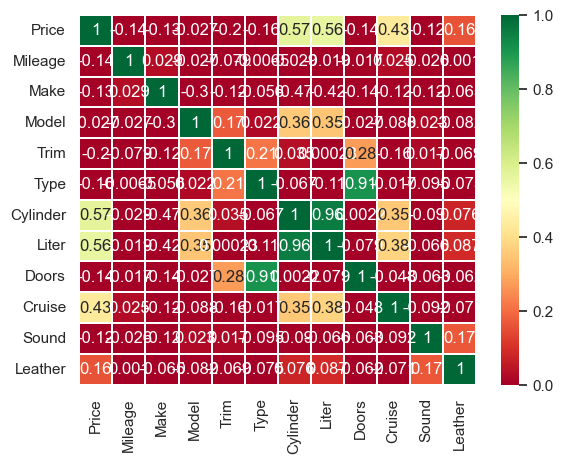

In [16]:
# Read dataframe
data = pd.read_excel('kuiper.xls')
data.dropna(inplace=True)
display(data)

# Normalization
data = norm_data(data)
display(data)

# Correlation
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

# Dependent variable
explore_column = 'Price' 

### Линейная регрессия

In [17]:
class LinearRegressionResearch:
    def __init__(self, df, column, influence_measures_filename=None):
        self.filename = influence_measures_filename
        
        self.df = df
        self.column = column
        self.x = df.drop(columns=column)
        self.y = df[column]
        
        x_columns = "+".join(self.x.columns)
        model_formula = f'{self.column} ~ {x_columns}'
        self.model = ols(model_formula, data=self.df)
        self.results = self.model.fit()
        self.residuals = self.results.resid
        
    def info(self):
        # Использование библиотеки statsmodels для получения summary
        print(self.results.summary(title=self.column))
        
        # Вывод уравнения(закона) регрессии
        intercept = self.results.params[0]
        coefficients = self.results.params[1:]
        output_str = f'Law:\n{self.column} = '
        for i, c in enumerate(self.results.params.index[1:]):
            output_str += f'({coefficients[i]}) * {c} + '
            if i % 2 != 0:
                output_str += '\n'
        output_str += f'({intercept})'
        print(output_str)
        
        # Проведём анализ дисперсии модели
        print('==============================================================================')
        anova_result = anova_lm(self.results)
        print(anova_result)
        
        # Получение мер влиятельности для каждого наблюдения
        print('==============================================================================')
        influence = self.results.get_influence()
        influence_measures = influence.summary_frame()
        if self.filename is not None:
            influence_measures.to_csv(f'{self.filename}.csv', index=False)
        display(influence_measures)
    
    def draw_plots(self):
        # Scatter plots
        scatter_plots  = sns.pairplot(data, x_vars=self.df.columns, y_vars=self.df.columns, kind='reg')
        scatter_plots.fig.suptitle("Pair-plot with Regression Lines", y=1, fontsize=20)
        plt.show()

        # Residuals vs Fitted
        plt.scatter(self.results.predict(self.x), self.residuals)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Fitted')
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.show()

        # Residuals vs Fitted
        plt.scatter(self.results.predict(self.x), np.sqrt(zscore(self.residuals)))
        plt.title('Scale-Location')
        plt.xlabel('Fitted values')
        plt.ylabel('\u221AStandardized residuals')
        plt.show()

        # Normal Q-Q plot
        QQ = ProbPlot(zscore(self.residuals))
        QQ.qqplot(line='45', alpha=0.5, lw=1)
        plt.title('Normal Q-Q')
        plt.xlabel('Theoretical Quantiles')
        plt.ylabel('Standardized residuals')
        plt.show()
        
        # График Residuals vs Leverage
        fig, ax = plt.subplots(figsize=(12, 8))
        sm.graphics.influence_plot(self.results, criterion="cooks", size=25, plot_alpha=0.5, ax=ax)
        plt.title('Residuals vs Leverage', fontsize=20)
        plt.show()
    
    def run_tests(self):
        print('==============================================================================')
        # Теста Бройша-Пагана (Breusch-Pagan test) на гетероскедастичность.
        het_test = sms.het_breuschpagan(self.residuals, self.model.exog)
        print(f'Breusch-Pagan test: \n'
              f'LM statistic: {het_test[0]}      LM-Test p-value: {het_test[1]:} \n'
              f'F-statistic: {het_test[2]}       F-Test p-value: {het_test[3]:} \n')
        
        # Проводим тест Дарбина-Уотсона (Durbin-Watson test) на автокорреляцию остатков.
        durbin_watson_statistic = sms.durbin_watson(self.residuals)
        print(f'Durbin-Watson test:\n'
              f'statistic: {durbin_watson_statistic} \n')
        
        # Проводим тесты на нормальность распределения остатков. 
        jarque_bera_test = sms.jarque_bera(self.residuals)
        print(f'Jarque-Bera test:\n'
              f'statistic: {jarque_bera_test[0]}      p-value: {jarque_bera_test[1]}')
        omni_normtest_statistic, omni_normtest_p_value = sms.omni_normtest(self.residuals)
        print(f'Omni-normtest test:\n'
              f'statistic: {omni_normtest_statistic}      p-value: {omni_normtest_statistic}')
        
        # Проверяем модель на мультиколлинеарность данных.
        print('==============================================================================')
        vif_tol_data = pd.DataFrame()
        vif_tol_data["Variable"] = self.x.columns
        vif_tol_data["VIF"] = [variance_inflation_factor(self.x.values, i) for i in range(self.x.shape[1])]
        vif_tol_data["Tolerance"] = 1 / vif_tol_data["VIF"]
        display(vif_tol_data)

### Строим базовую модель

In [18]:
base_research = LinearRegressionResearch(data, column=explore_column, influence_measures_filename='influence_measures')
base_research.info()

                                    Price                                     
Dep. Variable:                  Price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     72.33
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          1.10e-111
Time:                        17:01:04   Log-Likelihood:                 616.99
No. Observations:                 804   AIC:                            -1210.
Df Residuals:                     792   BIC:                            -1154.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1893      0.026      7.289      0.0

,dfb_Intercept,dfb_Mileage,dfb_Make,dfb_Model,dfb_Trim,dfb_Type,dfb_Cylinder,dfb_Liter,dfb_Doors,dfb_Cruise,dfb_Sound,dfb_Leather,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.039337,0.051740,0.064289,0.047192,-0.048393,-0.036718,-0.056960,0.061735,0.039385,-0.024177,-0.022214,-0.020519,0.001647,-1.145798,0.014830,-0.140581,-1.146025,-0.140609
1,-0.042182,0.029312,0.042778,0.039021,-0.027057,-0.024511,-0.036543,0.036181,0.026970,-0.006128,-0.023651,0.046676,0.000801,-0.717436,0.018334,-0.098046,-0.717216,-0.098016
2,-0.041605,0.018520,0.047740,0.043575,-0.031161,-0.027370,-0.041240,0.040721,0.030167,-0.006561,-0.026771,0.052140,0.000936,-0.800836,0.017220,-0.106007,-0.800655,-0.105983
3,-0.063242,0.010280,0.065834,0.044386,-0.036372,-0.022866,-0.035336,0.038650,0.028579,-0.005459,0.041233,0.046330,0.001189,-0.887785,0.017777,-0.119436,-0.887666,-0.119420
4,-0.046058,-0.003831,0.082622,0.043105,-0.054744,-0.027696,-0.045883,0.055524,0.034019,-0.021446,0.069480,-0.035875,0.001840,-1.168870,0.015903,-0.148587,-1.169140,-0.148622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.015629,0.024067,-0.141273,-0.059323,0.035200,0.012276,-0.112971,0.102247,-0.021806,-0.032284,0.027019,0.059321,0.003885,-1.475494,0.020967,-0.215929,-1.476593,-0.216090
800,0.050656,0.002022,-0.139582,-0.045170,0.030504,-0.000223,-0.112871,0.097840,-0.011555,-0.029643,-0.079090,0.067459,0.003305,-1.264057,0.024223,-0.199160,-1.264535,-0.199235
801,0.054790,-0.005792,-0.142638,-0.046140,0.030634,-0.000241,-0.115607,0.100183,-0.011766,-0.030140,-0.081038,0.068974,0.003454,-1.291720,0.024240,-0.203592,-1.292266,-0.203678
802,0.063909,-0.035312,-0.136540,-0.044095,0.027288,-0.000278,-0.111670,0.096659,-0.011103,-0.028277,-0.078394,0.066170,0.003268,-1.236356,0.025015,-0.198036,-1.236769,-0.198102


### Попытаемся улучшить базовую модель при помощи (AIC/BIC) 

In [19]:
def stepwise_selection(df, column, criteria: str = 'AIC'):
    """ 
        Улучшаем модель при помощи:
            ::AIC (Akaike Information Criterion) 
                            или
            ::BIC (Bayesian Information Criterion) 
    """
    
    # Проверка, что criteria является строкой и принимает только 'AIC' или 'BIC'
    if not isinstance(criteria, str) or criteria not in ['AIC', 'BIC']:
        raise ValueError("Параметр 'criteria' должен быть строкой ('AIC' или 'BIC').")
    else:
        criteria = criteria.upper()
    
    
    drop_index = None
    output = ('                                    STEPS                                     \n'
              '==============================================================================\n')
    
    x = df.drop(columns=column)
    y = df[column]
    remaining_features = list(x.columns)
    best_model = sm.OLS(y, sm.add_constant(x[remaining_features])).fit()
    best_criterion = best_model.aic if criteria == 'AIC' else best_model.bic
    
    k = True
    while k:
        k = False
        output += (f'Selected Features: {remaining_features} \n'
                   f'{criteria}: {best_criterion} \n')
        
        for index in range(len(remaining_features)):
            features = remaining_features[:index] + remaining_features[(index+1):]
            model = sm.OLS(y, sm.add_constant(x[features])).fit()
            criterion = model.aic if criteria == 'AIC' else model.bic
    
            if criterion < best_criterion:
                k = True
                best_criterion = criterion
                best_model = model
                drop_index = index

        if k:
            remaining_features.pop(drop_index)
    
    print(output)
    return best_model, remaining_features

In [20]:
# Пошаговый отбор признаков с использованием AIC
new_model, selected_features = stepwise_selection(data, column=explore_column, criteria='AIC')

                                    STEPS                                     
Selected Features: ['Mileage', 'Make', 'Model', 'Trim', 'Type', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'] 
AIC: -1209.9803269004008 
Selected Features: ['Mileage', 'Make', 'Model', 'Trim', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather'] 
AIC: -1211.8336577695748 
Selected Features: ['Mileage', 'Make', 'Model', 'Trim', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather'] 
AIC: -1212.5075915952377 


### Проведём исследование улучшенной модели

                                    Price                                     
Dep. Variable:                  Price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     88.30
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          2.54e-113
Time:                        17:01:06   Log-Likelihood:                 616.25
No. Observations:                 804   AIC:                            -1213.
Df Residuals:                     794   BIC:                            -1166.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1826      0.025      7.212      0.0

,dfb_Intercept,dfb_Mileage,dfb_Make,dfb_Model,dfb_Trim,dfb_Cylinder,dfb_Doors,dfb_Cruise,dfb_Sound,dfb_Leather,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.033114,0.051047,0.064297,0.040815,-0.044315,0.008204,0.001188,-0.021150,-0.013695,-0.017950,0.001413,-1.101232,0.011517,-0.118867,-1.101380,-0.118883
1,-0.038097,0.028492,0.041605,0.033892,-0.024066,-0.003538,0.003600,-0.004950,-0.017777,0.045082,0.000714,-0.678829,0.015253,-0.084483,-0.678598,-0.084454
2,-0.037349,0.018487,0.046702,0.038060,-0.027920,-0.004367,0.004091,-0.005237,-0.020275,0.050631,0.000829,-0.761637,0.014098,-0.091076,-0.761435,-0.091052
3,-0.058657,0.010731,0.065065,0.040310,-0.033589,0.006036,0.010595,-0.003736,0.044743,0.045603,0.001153,-0.852226,0.015624,-0.107367,-0.852079,-0.107348
4,-0.039592,-0.002416,0.082880,0.038919,-0.051344,0.021612,0.009331,-0.017887,0.074056,-0.032824,0.001736,-1.127059,0.013482,-0.131758,-1.127251,-0.131781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.035283,0.025054,-0.121830,-0.048523,0.030353,-0.054437,-0.049747,-0.014610,0.031957,0.060944,0.003076,-1.386253,0.015757,-0.175399,-1.387059,-0.175501
800,0.065227,0.004182,-0.120414,-0.037705,0.026719,-0.061950,-0.050193,-0.014559,-0.066564,0.066951,0.002530,-1.170539,0.018132,-0.159067,-1.170812,-0.159104
801,0.069654,-0.002981,-0.123212,-0.038561,0.026842,-0.063618,-0.051341,-0.014731,-0.068308,0.068561,0.002649,-1.197940,0.018125,-0.162761,-1.198269,-0.162806
802,0.077348,-0.030237,-0.117392,-0.036662,0.023699,-0.061474,-0.048845,-0.013407,-0.065824,0.065530,0.002500,-1.141962,0.018807,-0.158101,-1.142181,-0.158131


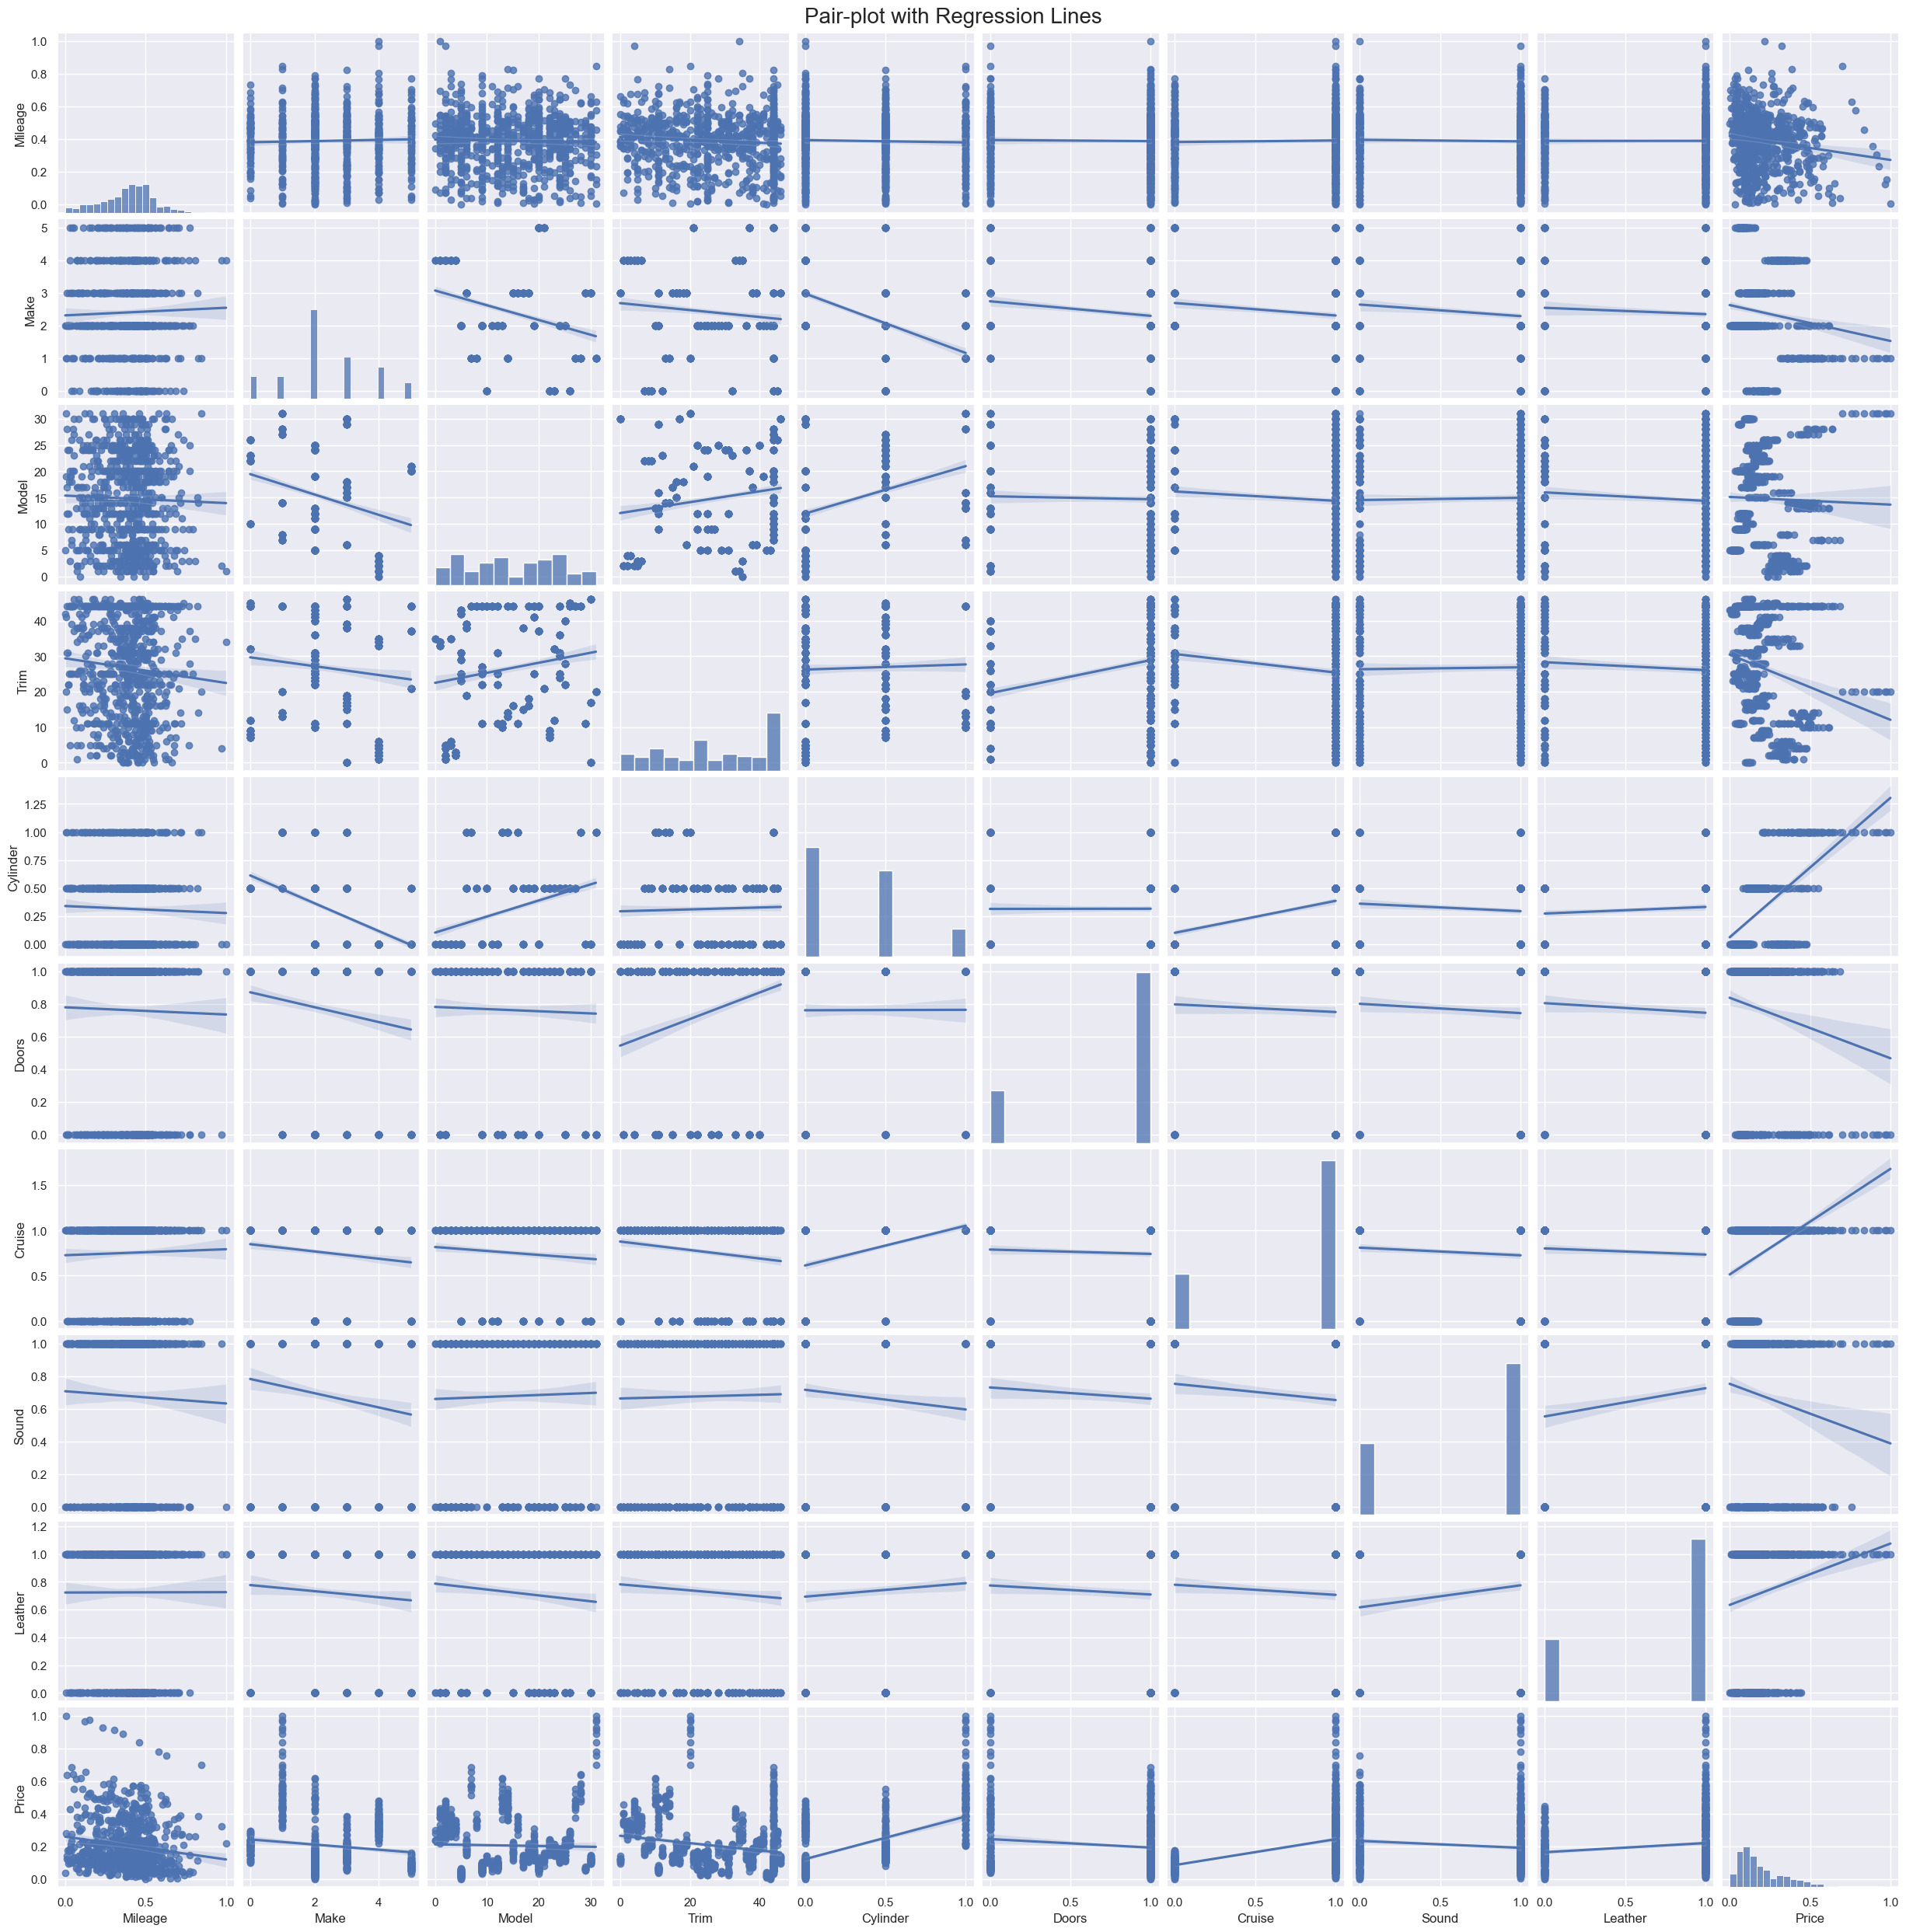

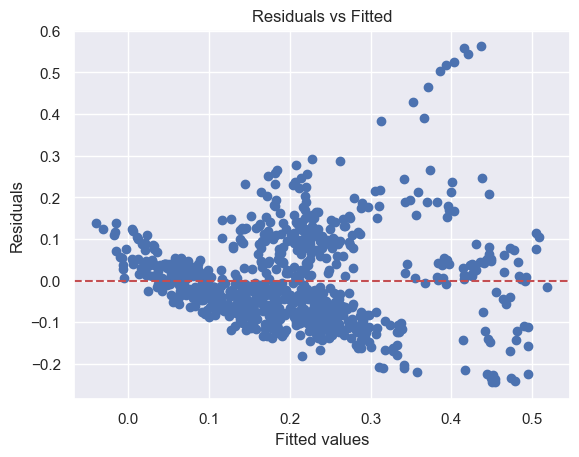

D:\PythonEnv\Matt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


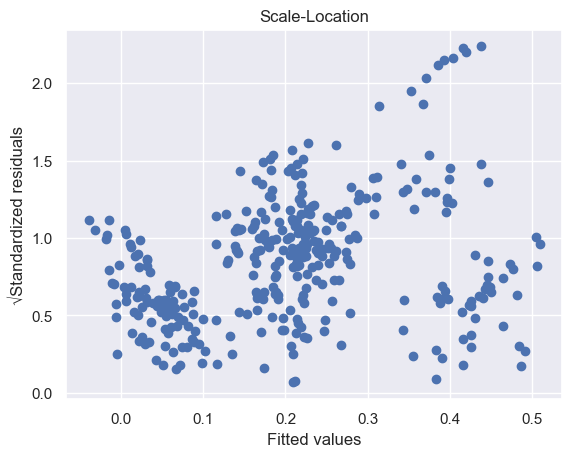

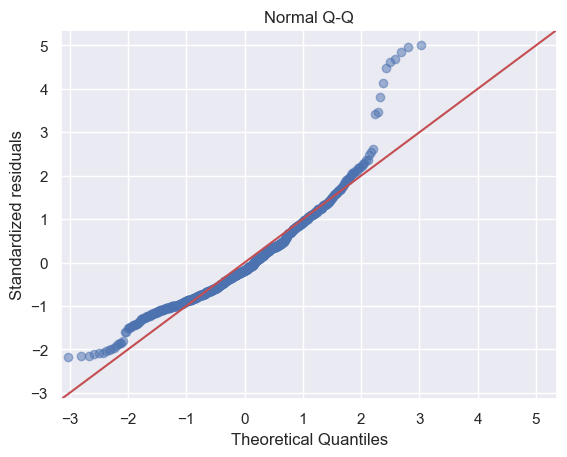

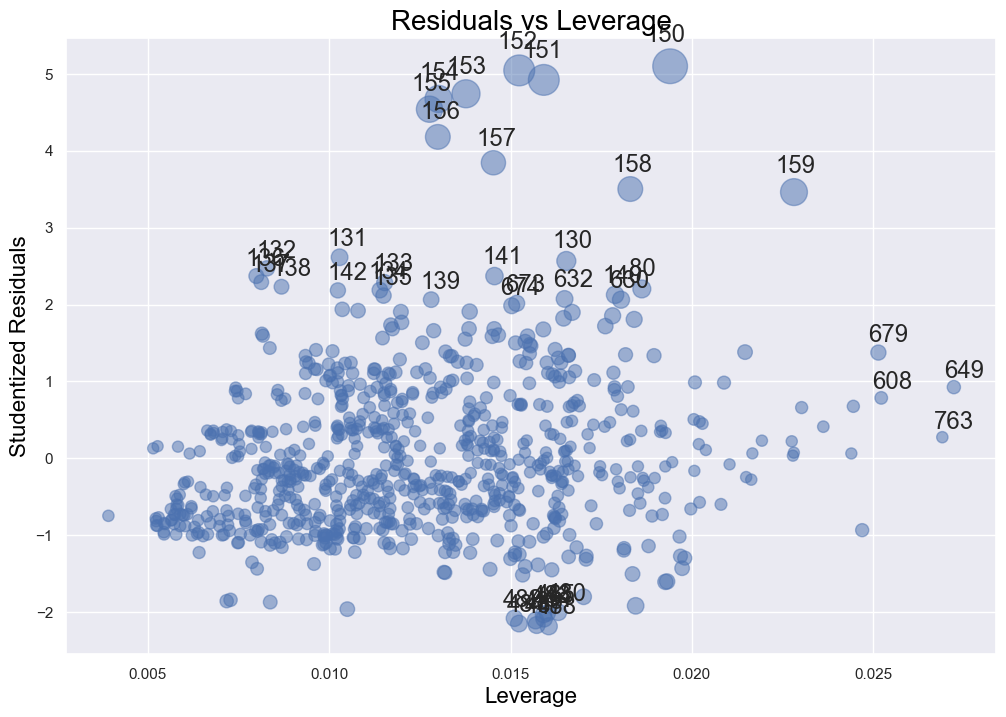

Breusch-Pagan test: 
LM statistic: 123.6476110886996      LM-Test p-value: 2.3907923310440827e-22 
F-statistic: 16.033554376387045       F-Test p-value: 2.6479000981633778e-24 

Durbin-Watson test:
statistic: 0.2263718453284863 

Jarque-Bera test:
statistic: 627.6090728459271      p-value: 5.205008406882042e-137
Omni-normtest test:
statistic: 206.6345953692554      p-value: 206.6345953692554


,Variable,VIF,Tolerance
0,Mileage,5.684898,0.175905
1,Make,4.023498,0.248540
2,Model,4.343273,0.230241
3,Trim,4.720745,0.211831
4,Cylinder,3.097732,0.322817
5,Doors,4.166586,0.240005
6,Cruise,4.307424,0.232157
7,Sound,3.055368,0.327293
8,Leather,3.486773,0.286798


In [21]:
enhanced_research = LinearRegressionResearch(data[selected_features + [explore_column]], column=explore_column)
enhanced_research.info()
enhanced_research.draw_plots()
enhanced_research.run_tests()

### Попытаемся улучшить уже улучшенную модель при помощи (Box-Cox)

                                   Price_t                                    
Dep. Variable:                Price_t   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     113.5
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          3.76e-136
Time:                        17:01:36   Log-Likelihood:                 1567.0
No. Observations:                 804   AIC:                            -3114.
Df Residuals:                     794   BIC:                            -3067.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0883      0.008     11.376      0.0

,dfb_Intercept,dfb_Mileage,dfb_Make,dfb_Model,dfb_Trim,dfb_Cylinder,dfb_Doors,dfb_Cruise,dfb_Sound,dfb_Leather,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.022905,0.035310,0.044475,0.028232,-0.030654,0.005675,0.000822,-0.014630,-0.009473,-0.012417,0.000677,-0.762042,0.011517,-0.082255,-0.761840,-0.082233
1,-0.021775,0.016285,0.023781,0.019372,-0.013756,-0.002022,0.002058,-0.002829,-0.010161,0.025768,0.000233,-0.388081,0.015253,-0.048298,-0.387873,-0.048272
2,-0.029270,0.014488,0.036600,0.029827,-0.021880,-0.003422,0.003206,-0.004104,-0.015889,0.039679,0.000510,-0.596964,0.014098,-0.071385,-0.596722,-0.071356
3,-0.044932,0.008220,0.049840,0.030878,-0.025729,0.004623,0.008116,-0.002862,0.034273,0.034932,0.000677,-0.652933,0.015624,-0.082259,-0.652697,-0.082229
4,-0.029566,-0.001805,0.061893,0.029064,-0.038343,0.016139,0.006968,-0.013358,0.055303,-0.024512,0.000969,-0.841961,0.013482,-0.098429,-0.841807,-0.098411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,0.045766,0.032498,-0.158025,-0.062940,0.039370,-0.070610,-0.064527,-0.018950,0.041452,0.079051,0.005168,-1.796628,0.015757,-0.227323,-1.799157,-0.227643
800,0.090348,0.005793,-0.166788,-0.052226,0.037009,-0.085808,-0.069523,-0.020166,-0.092200,0.092735,0.004847,-1.620057,0.018132,-0.220153,-1.621719,-0.220379
801,0.098789,-0.004229,-0.174748,-0.054690,0.038070,-0.090227,-0.072815,-0.020893,-0.096879,0.097238,0.005319,-1.697450,0.018125,-0.230628,-1.699467,-0.230902
802,0.115587,-0.045185,-0.175428,-0.054787,0.035414,-0.091865,-0.072992,-0.020036,-0.098366,0.097926,0.005571,-1.704789,0.018807,-0.236022,-1.706842,-0.236306


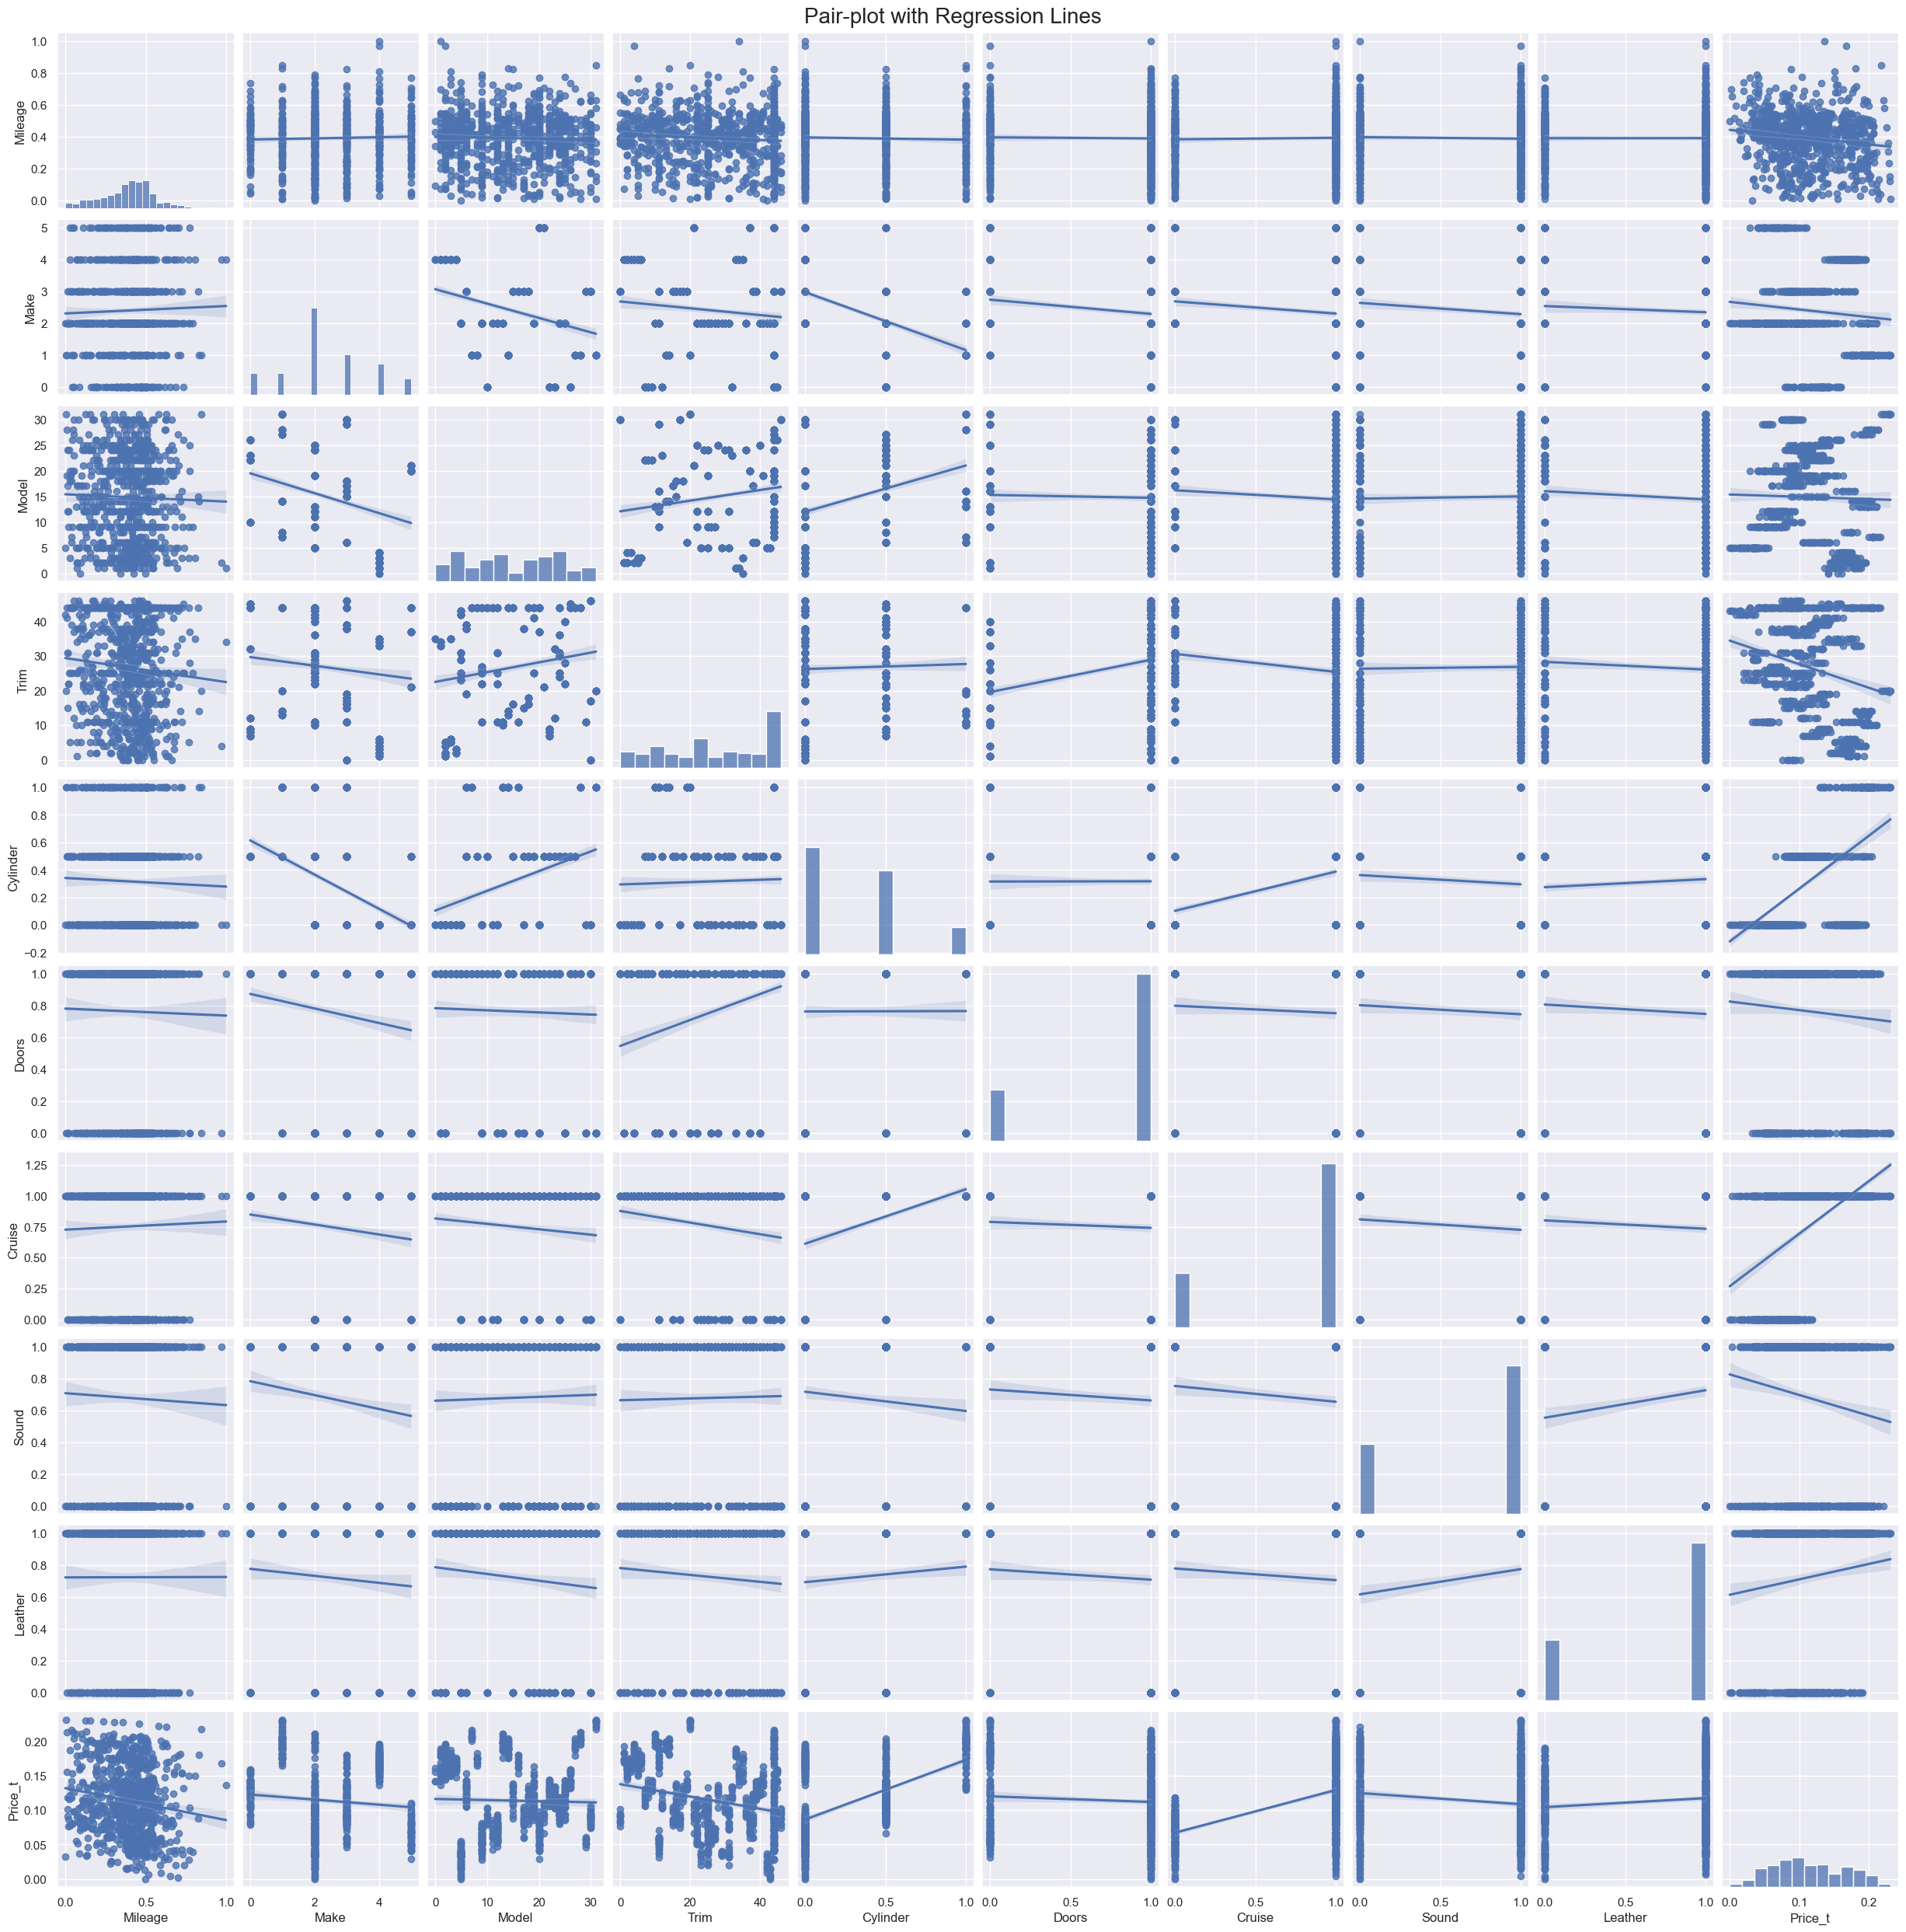

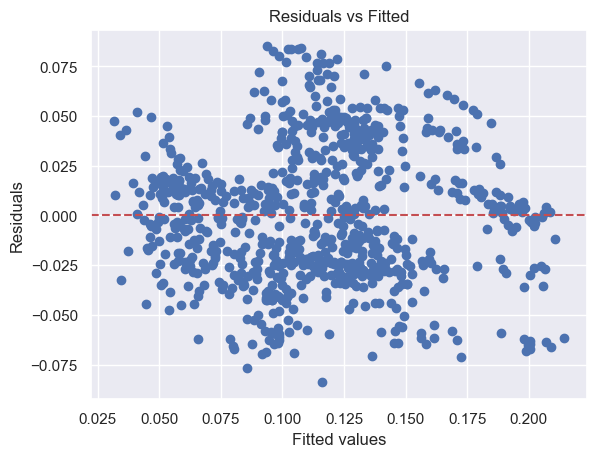

D:\PythonEnv\Matt\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


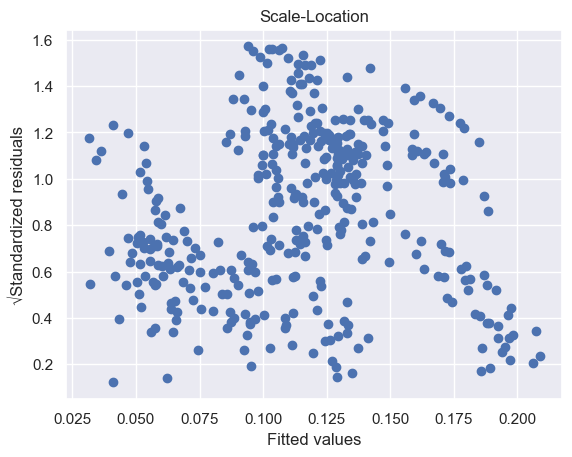

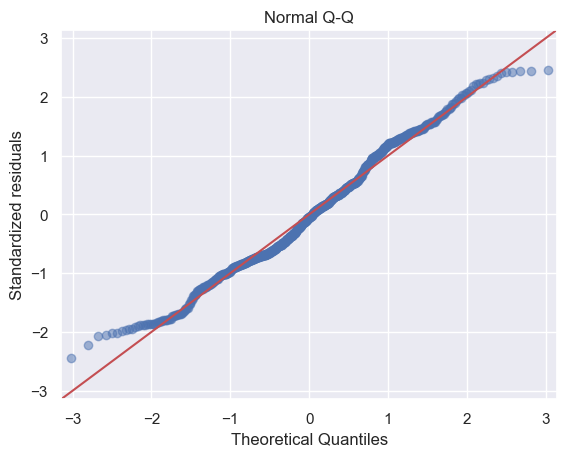

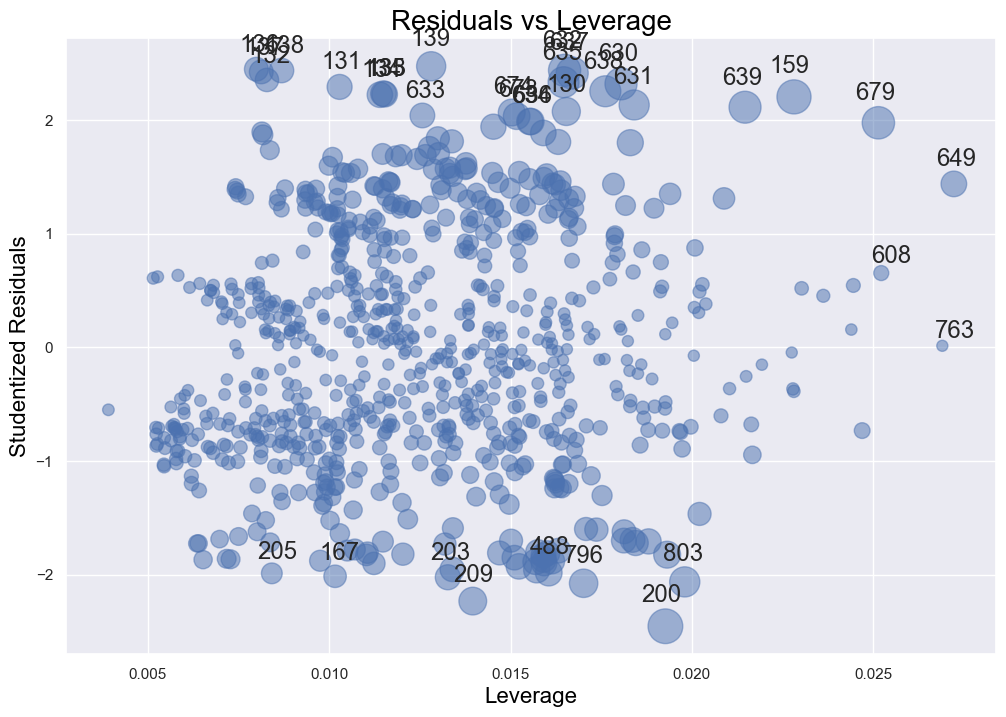

Breusch-Pagan test: 
LM statistic: 148.13408394133802      LM-Test p-value: 2.147149382709389e-27 
F-statistic: 19.925899108605527       F-Test p-value: 2.3636355366990558e-30 

Durbin-Watson test:
statistic: 0.32499195962555044 

Jarque-Bera test:
statistic: 15.78859427302434      p-value: 0.00037286388051768516
Omni-normtest test:
statistic: 25.39540339654083      p-value: 25.39540339654083


,Variable,VIF,Tolerance
0,Mileage,5.684898,0.175905
1,Make,4.023498,0.248540
2,Model,4.343273,0.230241
3,Trim,4.720745,0.211831
4,Cylinder,3.097732,0.322817
5,Doors,4.166586,0.240005
6,Cruise,4.307424,0.232157
7,Sound,3.055368,0.327293
8,Leather,3.486773,0.286798


In [22]:
# Применяем преобразование Бокса-Кокса к зависимой переменной
y_transformed, lambda_value = boxcox(data[explore_column] + 1)  # + 1 чтобы не было 0-значений
new_explore_column = explore_column + '_t'
data[new_explore_column] = y_transformed

# Проводим анализ заново
enhanced_research = LinearRegressionResearch(data[selected_features + [new_explore_column]],
                                             column=new_explore_column)
enhanced_research.info()
enhanced_research.draw_plots()
enhanced_research.run_tests()